# Narrative checker

Each fall, the Facilities Maintenance Division must report to the city not only its KPIs but also a "narrative section" in which changes over the previously reported KPI are explained. This notebook is designed to test a series of theories and hypotheses offered by FMD leadership. 

While this notebook was originally prepared in December 2020 to explain the FY2020 data, the Business Process Improvement Office expects it to be useful in future years as well. 

## Setup

In [1]:
# workhorse modules
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import re
from pathlib import Path
import pyodbc  # for accessing the database directly
import seaborn as sns

# local utility functions
from utils import *
from vis_utils import fmd_line_plot
from private.config import config

In [2]:
set_pd_params()
sns.set_style("white")
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
query_path = Path.cwd() / "sql" / "input_for_FMD_KPIs.sql"
kpis_raw = get_kpi_data(config, query_path)

print(f"The KPIs raw dataframe has {kpis_raw.shape[0]:,} rows.")
print(f"The earliest request date is {min(kpis_raw['date_requested'].dt.date)}")
kpis_raw[["wr_id", "date_requested", "problem_type"]].sample(3, random_state=444)

The KPIs raw dataframe has 104,953 rows.
The earliest request date is 2013-10-11


,wr_id,date_requested,problem_type
23883,28931,2015-04-24,OTHER
54911,84072,2017-02-21,_DELIVERY
33125,54832,2015-11-04,ELEC/LIGHT


In [4]:
def all_cleaning(df, start_date):
    df = df.copy()
    df = tidy_up_wr(df)
    # glue the date and time for request
    df = glue_date_time(df, "date_requested", "time_requested", "requested_dt")
    # glue the date and time for completion
    df = glue_date_time(df, "date_completed", "time_completed", "completed_dt")
    # convert "date closed_order" to date time (this column has no time information)
    df["date_closed"] = df["date_closed"].astype("datetime64")
    date_cond = df["requested_dt"] > pd.Timestamp(start_date)
    df = df[date_cond]
    df = compute_days_to_completion(df)
    # df = entirely_within_fiscal_year(df)
    df = add_fiscal_year(df, assign_fy_on="completion")
    return df


df_cleaned_1 = all_cleaning(kpis_raw, start_date="07-01-2018")

print(f"The earliest request date is {min(df_cleaned_1['requested_dt'].dt.date)}")

The earliest request date is 2018-07-01


In [5]:
def consolidate(df):
    df["problem_type"] = df["problem_type"].replace("_DELIVERY", "DELIVERY")
    df["problem_type"] = df["problem_type"].replace(
        [
            "HVAC|REPAIR",
            "CHILLERS",
            "BOILER",
            "COOLING TOWERS",
            "HVAC",
            "HVAC INFRASTRUCTURE",
        ],
        "HVAC",
    )
    df["problem_type"] = df["problem_type"].replace(
        ["HVAC|PM", "PREVENTIVE MAINT",], "PREVENTIVE",
    )
    df["problem_type"] = df["problem_type"].replace(
        r"^ELEC.*", "ELECTRICAL", regex=True
    )
    df["problem_type"] = df["problem_type"].replace(r"^PLUMB.*", "PLUMBING", regex=True)

    return df


df_cleaned = consolidate(df_cleaned_1)

## KPI 1: PM Compliance

Note that we're testing the traditional KPI here: "% of PMs Completed in 26 days"

In [6]:
def prep_pm_compliance(df):
    df = df.copy()

    cond_fy = df["fiscal_year"].isin(range(2016, 2021))
    cond_pm = df["problem_type"].isin(['PREVENTIVE'])

    df = df[cond_fy & cond_pm]
    df = compute_is_on_time(df, 26)
    return df


pm_compliance_input = prep_pm_compliance(df_cleaned)
print(f"The filtered work orders dataframe has {pm_compliance_input.shape[0]:,} rows.")

The filtered work orders dataframe has 2,354 rows.


In [7]:
pm_compliance_input.sample(3, random_state=444)

,wr_id,description,date_closed,pmp_id,bl_id,cost_total,cost_labor,cost_parts,problem_type,requestor,supervisor,po_number,invoice_number,release_number,name,status,requested_dt,completed_dt,days_to_completion,calendar_year,month,fiscal_year,is_on_time
requested_dt,,,,,,,,,,,,,,,,,,,,,,,
2019-09-27 07:00:25,126188,1. Is call box in operation?\n2. Did you get a...,2020-03-26 09:43:00.910,ELEVATOR TEST,B00050,0.0,0.0,0.0,PREVENTIVE,None,CHARLES.CLARIDY,None,None,None,Charles L. Benton Jr. Building,Clo,2019-09-27 07:00:25,2019-10-01 08:39:59,4.07,2019.0,10.0,2020.0,True
2018-08-19 07:00:04,109638,Inspect Basement within 30 minutes of shift fo...,2020-01-24 13:20:52.403,BASEMENT INSPECT,B00063,0.0,0.0,0.0,PREVENTIVE,CHARLES.CLARIDY,CHARLES.CLARIDY,None,None,None,District Court of Maryland People's Court,Clo,2018-08-19 07:00:04,2018-08-22 08:12:29,3.05,2018.0,8.0,2019.0,True
2018-12-24 06:01:24,114468,02. Order Fuel If Necessary\n\nTonya Smith 1/4...,2020-03-26 12:37:24.003,HEAT LEV B90050,B90050,0.0,0.0,0.0,PREVENTIVE,None,None,None,None,None,P.S. 005 - Langston Hughes Elementary,Clo,2018-12-24 06:01:24,2019-07-05 09:48:13,193.16,2019.0,7.0,2020.0,False


### Theory 1: PM duplicates
If two PMs are scheduled for:
- the same building
- the same day
- the same PMP ID

Then they are duplicates. 

In [8]:
pd.set_option("display.max_colwidth", 300)
df_cleaned[df_cleaned["wr_id"] == 129606]["description"]

requested_dt
2020-01-07 06:00:20    1. FLUID LEVELS CHECKED?\n2. ACCEPTABLE LEVELS?\n3. IF NO, WAS IT CORRECTED?\n4. GENERATOR START?\n5. IF NO, WAS W/R PLACED TO CM ELECTRICAL?\n6. WHAT WAS W/R NUMBER?
Name: description, dtype: object

In [9]:
def spot_pm_dupes(df):
    df = df.copy()
    df = df.reset_index(drop=True)
    df = df.assign(
        filt=df.groupby(by=["bl_id", "pmp_id"], group_keys=False).apply(
            lambda x: x["requested_dt"] - x["requested_dt"].shift(1)
        )
        / timedelta(days=1)
    )
    df["is_pm_dupe"] = df["filt"] < 1.0
    df = df.drop(columns="filt")
    return df


pm_dupes = spot_pm_dupes(pm_compliance_input)

pm_dupes[pm_dupes["requested_dt"] > "01-01-2020"][
    [
        "wr_id",
        "description",
        "bl_id",
        "is_pm_dupe",
        "days_to_completion",
        "pmp_id",
        "requested_dt",
    ]
].sort_values(["bl_id", "requested_dt"]).head(3)

,wr_id,description,bl_id,is_pm_dupe,days_to_completion,pmp_id,requested_dt
2018,129605,"1. FLUID LEVELS CHECKED?\n2. ACCEPTABLE LEVELS?\n3. IF NO, WAS IT CORRECTED?\n4. GENERATOR START?\n5. IF NO, WAS W/R PLACED TO CM ELECTRICAL?\n6. WHAT WAS W/R NUMBER?",B00020,False,77.38,GENERATOR PM,2020-01-07 06:00:15
2019,129606,"1. FLUID LEVELS CHECKED?\n2. ACCEPTABLE LEVELS?\n3. IF NO, WAS IT CORRECTED?\n4. GENERATOR START?\n5. IF NO, WAS W/R PLACED TO CM ELECTRICAL?\n6. WHAT WAS W/R NUMBER?",B00020,True,77.38,GENERATOR PM,2020-01-07 06:00:20
2020,129607,"1. FLUID LEVELS CHECKED?\n2. ACCEPTABLE LEVELS?\n3. IF NO, WAS IT CORRECTED?\n4. GENERATOR START?\n5. IF NO, WAS W/R PLACED TO CM ELECTRICAL?\n6. WHAT WAS W/R NUMBER?",B00020,True,77.38,GENERATOR PM,2020-01-07 06:00:25


In [10]:
def compute_kpi_table(df, label_for_totals):
    df = df.copy()
    table_df = df.groupby("fiscal_year")[["is_pm_dupe"]].agg(["mean", "count"])
    table_df.columns = table_df.columns.droplevel(0)
    table_df["mean"] = table_df["mean"].apply(lambda x: round(x * 100, 2))
    table_df = table_df.rename(
        columns={"mean": "% PMs That Are Duplicates", "count": label_for_totals}
    )
    return table_df


pm_dupes_by_fy = compute_kpi_table(pm_dupes, "total_PMs")
pm_dupes_by_fy

,% PMs That Are Duplicates,total_PMs
fiscal_year,,
2019.0,42.12,1002
2020.0,33.51,1352


### Theory 2: Outlying locations are concentrations of late PMs

## KPI 2: PM:CM Ratio

In [11]:
def prep_pm_cm(df):
    df = df.copy()

    cond_fy = df["fiscal_year"].isin(range(2019, 2022))
    cond_drop_current_month = df["requested_dt"] < datetime.today().replace(
        day=1, hour=1
    )
    cond_pm_cm = df["problem_type"].isin(['HVAC', 'PREVENTIVE'])

    df = df[cond_fy & cond_drop_current_month & cond_pm_cm]
    df = compute_is_on_time(df, 24)
    return df


pm_cm_input = prep_pm_cm(df_cleaned)
pm_cm_input[["wr_id", "requested_dt", "problem_type"]].sample(6)

,wr_id,requested_dt,problem_type
requested_dt,,,
2020-01-16 16:21:48,129969,2020-01-16 16:21:48,HVAC
2019-07-01 10:01:06,122796,2019-07-01 10:01:06,HVAC
2018-08-30 07:01:00,110095,2018-08-30 07:01:00,PREVENTIVE
2020-10-30 10:04:36,138117,2020-10-30 10:04:36,HVAC
2018-08-30 07:01:07,110125,2018-08-30 07:01:07,PREVENTIVE
2018-07-03 07:00:11,107631,2018-07-03 07:00:11,PREVENTIVE


### PM and CM Counts Per Month

In [12]:
pm_cm_counts_by_month = pm_cm_input.groupby(
    [pd.Grouper(freq="MS"), "problem_type"]
)["wr_id"].count()

pm_cm_counts_plot_data = pd.DataFrame(pm_cm_counts_by_month).reset_index()
pm_cm_counts_plot_data.head(4)

,requested_dt,problem_type,wr_id
0,2018-07-01,HVAC,224
1,2018-07-01,PREVENTIVE,102
2,2018-08-01,HVAC,219
3,2018-08-01,PREVENTIVE,316


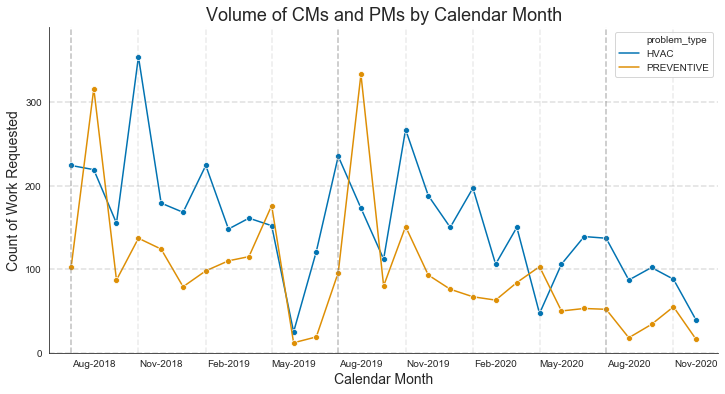

In [13]:
fmd_line_plot(
    pm_cm_counts_plot_data,
    "Volume of CMs and PMs by Calendar Month",
    ylabel="Count of Work Requested",
    yaxis_freq=100,
    x="requested_dt",
    y="wr_id",
    ymax=390,
    hue="problem_type",
)

### PM and CM Duration by Calendar Month

In [14]:
pm_cm_duration_by_cal_month = pm_cm_input.groupby(
    [pd.Grouper(freq="MS"), "problem_type"]
)["days_to_completion"].median()

pm_cm_duration_plot_data = pd.DataFrame(pm_cm_duration_by_cal_month).reset_index()
pm_cm_duration_plot_data.head(4)

,requested_dt,problem_type,days_to_completion
0,2018-07-01,HVAC,14.09
1,2018-07-01,PREVENTIVE,8.05
2,2018-08-01,HVAC,13.91
3,2018-08-01,PREVENTIVE,6.11


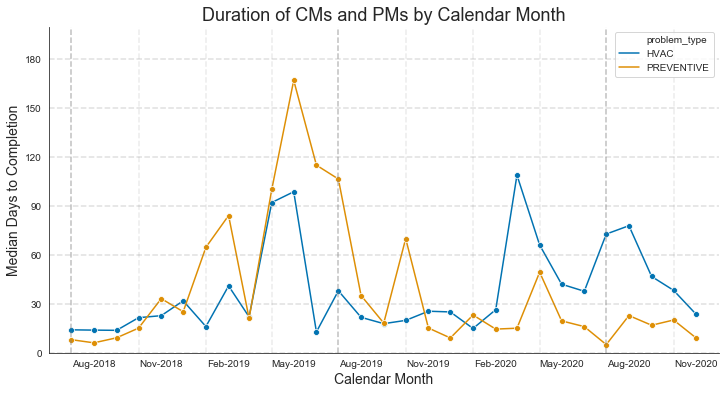

In [15]:
fmd_line_plot(
    pm_cm_duration_plot_data,
    "Duration of CMs and PMs by Calendar Month",
    ylabel="Median Days to Completion",
    yaxis_freq=30,
    x="requested_dt",
    y="days_to_completion",
    ymax=200,
    hue="problem_type",
)

In [16]:
pivot = pm_cm_counts_plot_data.pivot(
    index="requested_dt", columns="problem_type", values="wr_id"
)
pivot["pm_cm_ratio"] = pivot["PREVENTIVE"] / pivot["HVAC"]
pivot = pivot.reset_index()
pivot.head(3)

problem_type,requested_dt,HVAC,PREVENTIVE,pm_cm_ratio
0,2018-07-01,224,102,0.455357
1,2018-08-01,219,316,1.442922
2,2018-09-01,155,87,0.561290


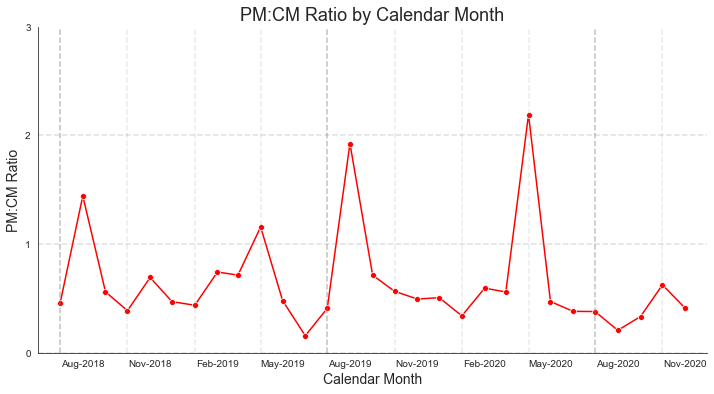

In [17]:
fmd_line_plot(
    pivot,
    "PM:CM Ratio by Calendar Month",
    ylabel="PM:CM Ratio",
    yaxis_freq=1,
    x="requested_dt",
    y="pm_cm_ratio",
    ymax=3,
)

## CM Compliance

Terrel writes:

> Can we show how corrective work order durations increased? I’m sure it happened from March 2020 through June but I just would like to know the average and the specific types.

### CM Volume

In [18]:
def prep_cm_compliance(df):
    df = df.copy()
    PM_list = [
        "HVAC|PM",
        "BUILDING PM",
        "BUILDING INTERIOR INSPECTION",
        "INSPECTION",
        "PREVENTIVE MAINT",
    ]

    cond_fy = df["fiscal_year"].isin(range(2019, 2022))
    cond_drop_current_month = df["requested_dt"] < datetime.today().replace(
        day=1, hour=1
    )
    cond_pm = df["problem_type"].isin(PM_list)

    df = df[cond_fy & cond_drop_current_month & ~cond_pm]
    df = compute_is_on_time(df, 24)
    return df


cm_compliance_input = prep_cm_compliance(df_cleaned)
cm_compliance_input[["wr_id", "requested_dt", "problem_type"]].tail()

,wr_id,requested_dt,problem_type
requested_dt,,,
2020-11-30 11:10:35,138761,2020-11-30 11:10:35,PLUMBING
2020-11-30 11:34:38,138768,2020-11-30 11:34:38,OTHER
2020-11-30 11:39:20,138770,2020-11-30 11:39:20,OTHER
2020-11-30 11:44:25,138771,2020-11-30 11:44:25,OTHER
2020-11-30 12:01:41,138773,2020-11-30 12:01:41,OTHER


In [19]:
fmd_plot_data = cm_compliance_input.groupby([pd.Grouper(freq="MS")])[["wr_id"]].count()
fmd_plot_data["requested_dt"] = fmd_plot_data.index
fmd_plot_data.tail()

,wr_id,requested_dt
requested_dt,,
2020-07-01,527,2020-07-01
2020-08-01,390,2020-08-01
2020-09-01,409,2020-09-01
2020-10-01,407,2020-10-01
2020-11-01,321,2020-11-01


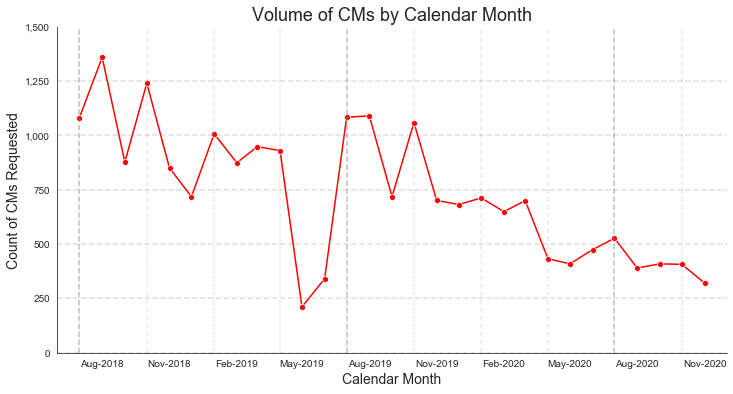

In [20]:
fmd_line_plot(
    fmd_plot_data,
    "Volume of CMs by Calendar Month",
    yaxis_freq=250,
    x="requested_dt",
    y="wr_id",
    ymax=1500,
)

### Grouped volume

In [30]:
problem_types_by_cal_month = cm_compliance_input.groupby(
    [pd.Grouper(freq="MS"), "problem_type"]
)["wr_id"].count()

problem_types_by_cal_month = (
    problem_types_by_cal_month.groupby(level="requested_dt")
    .nlargest(5)
    .reset_index(level=0, drop=True)
)

problem_types_by_cal_month.to_excel("problem_types.xlsx")
ptypes_plot_data = pd.DataFrame(problem_types_by_cal_month).reset_index()

problem_types_by_cal_month.tail(3)

requested_dt  problem_type
2020-11-01    HVAC            39
              ELECTRICAL      34
              DELIVERY        18
Name: wr_id, dtype: int64

In [22]:
cond_top_groups = cm_compliance_input["problem_type"].isin(
    ["OTHER", "HVAC", "ELECTRICAL", "PLUMBING"]
)
cm_compliance_top = cm_compliance_input[cond_top_groups]

problem_types_by_cal_month = cm_compliance_top.groupby(
    [pd.Grouper(freq="MS"), "problem_type"]
)["wr_id"].count()

ptypes_plot_data = pd.DataFrame(problem_types_by_cal_month).reset_index()
ptypes_plot_data.head(3)

,requested_dt,problem_type,wr_id
0,2018-07-01,ELECTRICAL,97
1,2018-07-01,HVAC,224
2,2018-07-01,OTHER,153


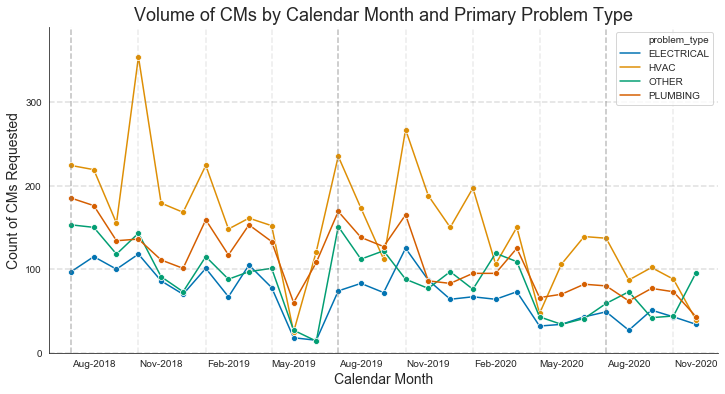

In [23]:
fmd_line_plot(
    ptypes_plot_data,
    "Volume of CMs by Calendar Month and Primary Problem Type",
    yaxis_freq=100,
    x="requested_dt",
    y="wr_id",
    ymax=390,
    hue="problem_type",
)

### Durations

In [24]:
cm_compliance_input.head(3)

,wr_id,description,date_closed,pmp_id,bl_id,cost_total,cost_labor,cost_parts,problem_type,requestor,supervisor,po_number,invoice_number,release_number,name,status,requested_dt,completed_dt,days_to_completion,calendar_year,month,fiscal_year,is_on_time
requested_dt,,,,,,,,,,,,,,,,,,,,,,,
2018-07-01 07:00:06,107555,Inspect Basement within 30 minutes of shift for water. If water is found they must take action or call the appropriate people to do so.,2020-01-24 12:48:15.273,BASEMENT INSPECT,B00063,0.00,0.0,0.0,PREVENTIVE,CHARLES.CLARIDY,CHARLES.CLARIDY,None,None,None,District Court of Maryland People's Court,Clo,2018-07-01 07:00:06,2018-07-11 08:07:34,10.05,2018.0,7.0,2019.0,True
2018-07-01 13:23:50,107556,low water pressure couldn't fill building \nfisher on site abel wolman\n\nTonya Smith 7/2/2018\nAssigned to Fischer,2018-09-11 08:25:06.787,None,B00057,7633.32,0.0,0.0,PLUMBING,JIMMY.HOLTHAUS,None,526184,J003716,None,Abel Wolman Muncipal Building,Clo,2018-07-01 13:23:50,2018-08-01 13:39:27,31.01,2018.0,8.0,2019.0,False
2018-07-01 13:28:17,107557,low water pressure in building \nfisher on site\n\nTonya Smith 7/2/2018\nAssigned to Fischer,2018-08-20 09:46:17.073,None,B00056,1260.00,0.0,0.0,PLUMBING,JIMMY.HOLTHAUS,None,526022,J003715,None,City Hall,Clo,2018-07-01 13:28:17,2018-07-17 09:41:55,15.84,2018.0,7.0,2019.0,True


In [25]:
fmd_plot_data = cm_compliance_input.groupby([pd.Grouper(freq="MS")])[
    ["days_to_completion"]
].median()
fmd_plot_data["requested_dt"] = fmd_plot_data.index
fmd_plot_data.tail()

,days_to_completion,requested_dt
requested_dt,,
2020-07-01,28.150,2020-07-01
2020-08-01,40.175,2020-08-01
2020-09-01,39.300,2020-09-01
2020-10-01,24.260,2020-10-01
2020-11-01,9.050,2020-11-01


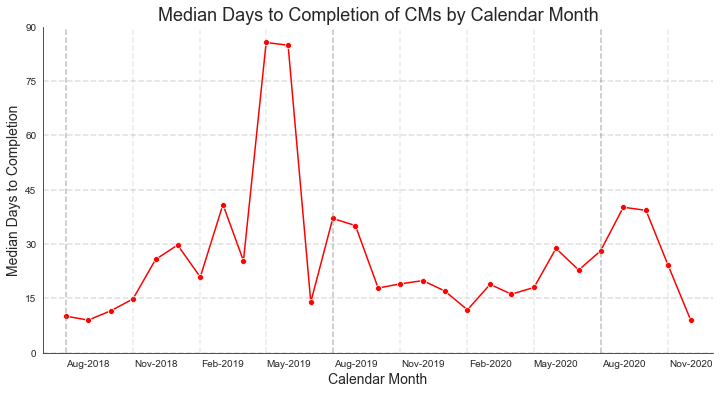

In [26]:
fmd_line_plot(
    fmd_plot_data,
    title="Median Days to Completion of CMs by Calendar Month",
    ylabel="Median Days to Completion",
    yaxis_freq=15,
    x="requested_dt",
    y="days_to_completion",
    ymax=90,
)

In [27]:
problem_types_by_cal_month = cm_compliance_input.groupby(
    [pd.Grouper(freq="MS"), "problem_type"]
)["days_to_completion"].median()

In [28]:
cond_top_groups = cm_compliance_input["problem_type"].isin(
   ["OTHER", "HVAC", "ELECTRICAL", "PLUMBING"]
)
cm_compliance_top = cm_compliance_input[cond_top_groups]

problem_types_by_cal_month = cm_compliance_top.groupby(
    [pd.Grouper(freq="MS"), "problem_type"]
)["days_to_completion"].median()

ptypes_plot_data = pd.DataFrame(problem_types_by_cal_month).reset_index()
ptypes_plot_data.head(3)

,requested_dt,problem_type,days_to_completion
0,2018-07-01,ELECTRICAL,7.84
1,2018-07-01,HVAC,14.09
2,2018-07-01,OTHER,2.05


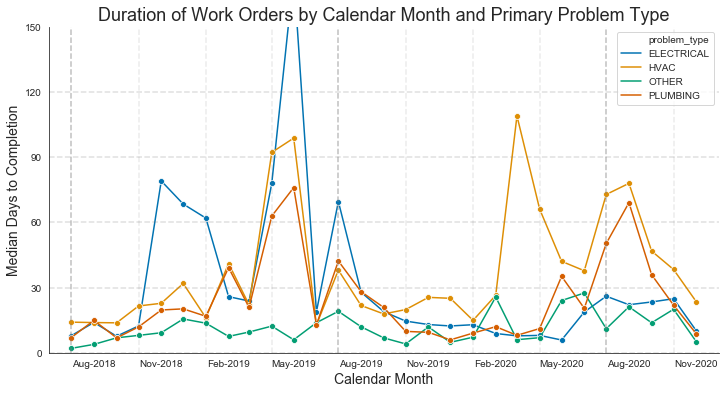

In [29]:
fmd_line_plot(
    ptypes_plot_data,
    "Duration of Work Orders by Calendar Month and Primary Problem Type",
    yaxis_freq=30,
    ylabel="Median Days to Completion",
    x="requested_dt",
    y="days_to_completion",
    ymax=150,
    hue="problem_type",
)